In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tp2datostrain/train.csv
/kaggle/input/tp2datostrain/test.csv
/kaggle/input/pingsound/PING - Sound effect.mp3


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
from IPython.display import Audio
sound_file = '/kaggle/input/pingsound/PING - Sound effect.mp3'
def ping():
    display(Audio(sound_file, autoplay=True))

In [4]:
import pandas as pd
test = pd.read_csv("../input/tp2datostrain/test.csv")
train = pd.read_csv("../input/tp2datostrain/train.csv")

In [5]:
dfCheto = pd.concat([train,test], sort=False)
#dfCheto['precio'] = SimpleImputer(strategy='median').fit_transform(dfCheto[['precio']])
df = dfCheto.copy()

In [67]:
ciudades = list(dfCheto["ciudad"].unique())
tipos_de_propiedad = list(dfCheto["tipodepropiedad"].unique())
provincia = list(dfCheto["provincia"].unique())
categorias  = [provincia, tipos_de_propiedad, ciudades]

In [6]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [7]:
df.provincia.isna().sum()

197

In [8]:
aux2 = dfCheto[['ciudad', 'provincia']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby(['provincia']).agg(lambda x:x.provincia.value_counts().index[0]).reset_index().set_index('ciudad')
dicc_ciudadPorPcia = aux2.T.to_dict('records').copy()[0]
dicc_ciudadPorPcia['CUALQUIERA'] = 'CUALQUIERCIUDAD'
df['ciudad'] =df['ciudad'].fillna('CUALQUIERA')
df['provincia'] = df['provincia'].fillna(df['ciudad'].map(dicc_ciudadPorPcia))

In [9]:
df.provincia.fillna('provinciaVacia',inplace=True)

In [10]:
df['provincia'].isna().sum()

0

In [11]:
aux2 = dfCheto[['ciudad', 'provincia']].copy()
aux2 = aux2.groupby(['provincia']).agg(lambda x:x.provincia.value_counts().index[0]).reset_index().set_index('ciudad')
aux2.head()
dicc_ciudadMasFrecuentePorPcia = aux2.T.to_dict('records').copy()[0]
dicc_invertido = dict(map(reversed, dicc_ciudadMasFrecuentePorPcia.items()))
df.ciudad.fillna(df.provincia.map(dicc_invertido),inplace=True);
df.ciudad.isna().sum()

0

In [12]:
df.ciudad.fillna('ciudadVacia',inplace=True)

In [13]:
df.tipodepropiedad.fillna('tipoVacio',inplace=True)
'''
auxmetros = df[['tipodepropiedad','metrostotales']].copy()
auxmetros = auxmetros.groupby('tipodepropiedad')['metrostotales'].mean().sort_values().reset_index()
lista = sorted(auxmetros.metrostotales.tolist())
lista_2 = [0]*len(lista)
for i,numero in enumerate(lista):
    if i == 0: lista_2[i] = (0,numero)
    else:
        lista_2[i] = (lista[i-1],lista[i])
rangoMetros = pd.Series(lista_2).sort_values()
auxmetros['rangoMetros'] = rangoMetros
auxmetros = auxmetros.set_index('tipodepropiedad').drop(columns='metrostotales')
dicc_tipoDeProp = auxmetros.T.to_dict('records').copy()[0]
def mapearMetros(metrostotales,dicc_tipoDeProp):
    for clave in dicc_tipoDeProp:
        if metrostotales >= dicc_tipoDeProp[clave][0] and metrostotales < dicc_tipoDeProp[clave][1]: return clave
    return 'Casa'
df.tipodepropiedad.fillna(df.metrostotales.map(lambda x: mapearMetros(x,dicc_tipoDeProp)),inplace=True);
df.tipodepropiedad.isna().sum()
'''

"\nauxmetros = df[['tipodepropiedad','metrostotales']].copy()\nauxmetros = auxmetros.groupby('tipodepropiedad')['metrostotales'].mean().sort_values().reset_index()\nlista = sorted(auxmetros.metrostotales.tolist())\nlista_2 = [0]*len(lista)\nfor i,numero in enumerate(lista):\n    if i == 0: lista_2[i] = (0,numero)\n    else:\n        lista_2[i] = (lista[i-1],lista[i])\nrangoMetros = pd.Series(lista_2).sort_values()\nauxmetros['rangoMetros'] = rangoMetros\nauxmetros = auxmetros.set_index('tipodepropiedad').drop(columns='metrostotales')\ndicc_tipoDeProp = auxmetros.T.to_dict('records').copy()[0]\ndef mapearMetros(metrostotales,dicc_tipoDeProp):\n    for clave in dicc_tipoDeProp:\n        if metrostotales >= dicc_tipoDeProp[clave][0] and metrostotales < dicc_tipoDeProp[clave][1]: return clave\n    return 'Casa'\ndf.tipodepropiedad.fillna(df.metrostotales.map(lambda x: mapearMetros(x,dicc_tipoDeProp)),inplace=True);\ndf.tipodepropiedad.isna().sum()\n"

In [14]:
aux2 = dfCheto[['idzona', 'ciudad']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby('ciudad').agg({'idzona':'median'})
ids = aux2.T.to_dict('records').copy()
ids = ids[0]
#df.idzona.fillna(df.ciudad.map(ids), inplace = True)

In [15]:
df['idzona'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['idzona']])

In [16]:
aux = dfCheto[['lat', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lat':'mean'})
lats = aux.T.to_dict('records').copy()
lats = lats[0]
#df.lat.fillna(df.ciudad.map(lats), inplace = True)

In [17]:
df['lat'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['lat']])

In [18]:
aux = dfCheto[['lng', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lng':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
#df.lng.fillna(df.ciudad.map(lngs), inplace = True)

In [19]:
df['lng'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['lng']])

In [20]:
aux = dfCheto[['tipodepropiedad', 'habitaciones']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'habitaciones':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
#df.habitaciones.fillna(df.tipodepropiedad.map(habts), inplace = True)

In [21]:
df['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['habitaciones']])

In [22]:
aux = dfCheto[['tipodepropiedad', 'garages']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'garages':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
#df.garages.fillna(df.tipodepropiedad.map(habts), inplace = True)

In [23]:
df.garages.fillna(0, inplace=True)

In [24]:
df.drop(columns=['direccion'], inplace=True)

In [25]:
aux = dfCheto[['antiguedad', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'antiguedad':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
#df.antiguedad.fillna(df.ciudad.map(lngs), inplace = True)

In [26]:
df['antiguedad'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['antiguedad']])

In [27]:
aux = dfCheto[['banos', 'tipodepropiedad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'banos':'median'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
#df.banos.fillna(df.tipodepropiedad.map(lngs), inplace = True)

In [28]:
df.banos.fillna(1, inplace=True)

In [29]:
aux = df.copy()

In [30]:
aux.metrostotales.fillna(0, inplace=True)
aux.metroscubiertos.fillna(0, inplace =True)
aux['metrostotalesCorregidos'] = aux[['metrostotales', 'metroscubiertos']].max(axis=1)
aux['metroscubiertosCorregidos'] = aux[['metrostotales', 'metroscubiertos']].min(axis=1)
df['metrostotales'] = aux['metrostotalesCorregidos']
df['metroscubiertos'] = aux['metroscubiertosCorregidos']

In [31]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['dia'] = df.fecha.dt.day
df['mes'] = df.fecha.dt.month
df['anio'] = df.fecha.dt.year
df.drop(columns=['fecha'], inplace=True)

In [32]:
df['publicacionesPorCiudad'] = CountEncoder().fit_transform(df['ciudad'])

In [33]:
df['publicacionesPorProvincia'] = CountEncoder().fit_transform(df['provincia'])

In [34]:
df['publicacionesPorTipo'] = CountEncoder().fit_transform(df['tipodepropiedad'])
df['publicacionesPorZona'] = CountEncoder().fit_transform(df['idzona'])
df['publicacionesPorBanos'] = CountEncoder().fit_transform(df['banos'])
df['publicacionesPorHabitaciones'] = CountEncoder().fit_transform(df['habitaciones'])
df['publicacionesPorAntiguedad'] = CountEncoder().fit_transform(df['antiguedad'])

In [35]:
df[['tipodepropiedad','provincia','ciudad']].isna().sum()

tipodepropiedad    0
provincia          0
ciudad             0
dtype: int64

### Datos por grupo

In [36]:
df['promedioAntiguedadZona'] = df.groupby('idzona').agg({'antiguedad':'mean'})
df['promedioAntiguedadCiudad'] = df.groupby('ciudad').agg({'antiguedad':'mean'})
df['promedioHabitacionesZona'] = df.groupby('idzona').agg({'habitaciones':'mean'})
df['promedioHabitacionesCiudad'] = df.groupby('ciudad').agg({'habitaciones':'mean'})
#df['promedioMetrosCubiertosZona'] = df.groupby('idzona').agg({'metroscubiertos': 'mean'})
#df['promedioMetrosCubiertosCiudad'] = df.groupby('ciudad').agg({'metroscubiertos': 'mean'})
#df['promedioMetrosTotalesZona'] = df.groupby('idzona').agg({'metrostotales': 'mean'})
#df['promedioMetrosTotalesCiudad'] = df.groupby('ciudad').agg({'metrostotales': 'mean'})
#df['promedioPrecioPorProvincia'] = df.groupby('provincia').agg({'precio': 'mean'})
#df['promedioPrecioPorIdzona'] = df.groupby('idzona').agg({'precio': 'mean'})
#df['promedioPrecioPorCiudad'] = df.groupby('ciudad').agg({'precio': 'mean'})

In [37]:
aux = train[['provincia', 'ciudad', 'idzona','precio', 'metrostotales']].copy()
aux['precioXM2'] = aux['precio'] / aux['metrostotales']
aux.groupby('provincia').agg({'precioXM2': 'mean'})

,precioXM2
provincia,
Aguascalientes,8191.787234
Baja California Norte,5968.995969
Baja California Sur,6485.002327
Campeche,8697.074357
Chiapas,11020.039292
Chihuahua,7651.501242
Coahuila,7042.142596
Colima,7313.212268
Distrito Federal,24011.411266


### Texto

In [38]:
df.titulo.fillna('', inplace=True)
df.descripcion.fillna('', inplace=True)
df["titulo_descripcion"] = df["titulo"].astype(str) + " " + df["descripcion"].astype(str)
#Como tiene algunos nulos los relleno con cadenas vaicas
df["titulo_descripcion"].fillna("",inplace = True)
#REMUEVO LA PUNTUACION
import string
print(string.punctuation)
tabla = {}
for c in string.punctuation + "¿¡":
    tabla[ord(c)] = None
def sacar_puntuacion(s):
    return s.translate(tabla)
df["titulo_descripcion"] = df["titulo_descripcion"].apply(sacar_puntuacion)
#Agrego los primeros features
df["nro_palabras"] = df["titulo_descripcion"].apply(lambda x: len(x.split(" ")))
df["nro_caracteres"] = df["titulo_descripcion"].apply(lambda x: len(x))
df["long_prom_palabra"] = df["nro_caracteres"] / df["nro_palabras"]

def llenarDiccionario(diccionario,descripcion):
    for palabra in descripcion.split():
        diccionario[palabra] = diccionario.get(palabra,0) + 1
        
def generarDiccionario(df2):
    dicc = {}
    for descripcion in df2['titulo_descripcion']:
        if isinstance(descripcion,str): llenarDiccionario(dicc,descripcion)
    return dicc
contador_palabras = generarDiccionario(df)

#Elimino las stopwords = palabras vacias que no suman nada
from nltk.corpus import stopwords
palabras_vacias = stopwords.words('spanish')

for palabra  in palabras_vacias:
    if palabra in contador_palabras:
        del contador_palabras[palabra]
ordenados = sorted(contador_palabras.items(),key = lambda x: -x[1])
top_50 = dict(ordenados[:50])

#Nuevos features
def contar_palabras_en_top(texto):
    palabras = texto.split()
    cont = 0
    for palabra in palabras:
        if palabra in top_50:
            cont += 1
    return cont
df["nro_palabras_mas_comunes"] = df["titulo_descripcion"].apply(contar_palabras_en_top)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [68]:
transformador_categorias = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', categories = categorias)),
])

transfomador_numero = Pipeline(steps=[('a', SimpleImputer(strategy = 'median'))])

In [40]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples',
       'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio',
       'dia', 'mes', 'anio', 'publicacionesPorCiudad',
       'publicacionesPorProvincia', 'publicacionesPorTipo',
       'publicacionesPorZona', 'publicacionesPorBanos',
       'publicacionesPorHabitaciones', 'publicacionesPorAntiguedad',
       'promedioAntiguedadZona', 'promedioAntiguedadCiudad',
       'promedioHabitacionesZona', 'promedioHabitacionesCiudad',
       'titulo_descripcion', 'nro_palabras', 'nro_caracteres',
       'long_prom_palabra', 'nro_palabras_mas_comunes'],
      dtype='object')

In [69]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transfomador_numero, [
            'id', 'antiguedad',
       'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
       'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos',
       'dia', 'mes', 'anio',
        #Canti de publicaciones
        'publicacionesPorCiudad',
       'publicacionesPorProvincia', 'publicacionesPorTipo',
            'publicacionesPorZona','publicacionesPorBanos',
            'publicacionesPorHabitaciones', 'publicacionesPorAntiguedad',
            
        #Texto
        "nro_palabras", "nro_caracteres", "long_prom_palabra", "nro_palabras_mas_comunes",
         #Promedios
            'promedioAntiguedadZona', 'promedioAntiguedadCiudad',
            'promedioHabitacionesZona', 'promedioHabitacionesCiudad',

            #'promedioPxM2Provincia',
                                     ]),
        ('cat', transformador_categorias, ['ciudad','tipodepropiedad', 'provincia', ])
    ])

In [86]:

model = xgb.XGBRegressor(learning_rate= 0.1,n_estimators= 1000,scale_pos_weight= 2,max_depth= 5,min_child_weight= 3,gamma= 0.0,colsample_bytree= 0.75,
                     subsample= 0.7,colsample_bylevel= 0.65, 
    #learning_rate= 0.1,n_estimators= 1500,scale_pos_weight= 2,max_depth= 5,min_child_weight= 5,gamma= 0.0,colsample_bytree= 0.75,subsample= 0.7,colsample_bylevel= 0.65, 
    tree_method='gpu_hist', gpu_id=0, eval_metric = "mae")

In [87]:
entrenamiento = df.head(240000).copy()

In [88]:
prueba = df.tail(60000).copy()

In [89]:
prueba.drop(columns=['precio'], inplace=True)

In [90]:
train_x = entrenamiento.drop(columns=['precio']).copy()
train_y = entrenamiento.precio.copy()
#train_x, test_x, train_y, test_y = train_test_split(train_x, train_y,train_size=0.8, test_size=0.2, random_state = 0)

In [91]:
from sklearn.ensemble import RandomForestClassifier
RF_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators = 1000, max_depth = 5))
                             ])

In [83]:
#X_train,X_test,y_train,y_test = train_test_split(train_x, train_y,test_size=0.3, random_state = 0)
#clf = RF_pipeline.fit(X_train, y_train)
#importancia_de_features = RF_pipeline.steps[1][1].feature_importances_
#for feature in sorted(zip(importancia_de_features,features),reverse=True):
  #print(feature)

In [92]:
train_x.tipodepropiedad = train_x.tipodepropiedad.astype(str)
train_x.provincia = train_x.provincia.astype(str)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [ ]:
my_pipeline.fit(train_x, train_y)

In [ ]:
preds = my_pipeline.predict(train_x)

In [ ]:
from sklearn.metrics import mean_absolute_error
ping()
mean_absolute_error(preds, train_y)

In [ ]:
preds_finales = my_pipeline.predict(prueba)

In [ ]:
res = pd.DataFrame(preds_finales, index=prueba.id, columns=['precio'])
res.reset_index(inplace=True)
res.columns = ["id", "target"]
display(res.head())
# RMSLE=1.0249284784393988 ?


# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "knn-results.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(res)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:53:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2.28024e+06	validation_1-mae:2.27622e+06
[1]	validation_0-mae:2.05356e+06	validation_1-mae:2.05001e+06
[2]	validation_0-mae:1.85379e+06	validation_1-mae:1.85088e+06
[3]	validation_0-mae:1.67843e+06	validation_1-mae:1.6757e+06
[4]	validation_0-mae:1.52522e+06	validation_1-mae:1.52316e+06
[5]	validation_0-mae:1.39654e+06	validation_1-mae:1.39557e+06
[6]	validation_0-mae:1.28515e+06	validation_1-mae:1.28516e+06
[7]	validation_0-mae:1.19233e+06	validation_1-mae:1.19345e+06
[8]	validation_0-mae:1.11277e+06	validation_1-mae:1.11498e+06
[9]	validation_0-mae:1.05193e+06	validation_1-mae:1.05533e+06
[10]	validation_0-mae:1.00024e+06	validation_1-mae:1.0045e+06
[11]	validation_0-mae:959306	validation_1-mae:964391
[12]	validation_0-mae:926504	validation_1-mae:931878
[13]	validation_0-mae:896444	validation_1-mae:902538
[14]	validation_0-mae:871946	vali

[150]	validation_0-mae:639339	validation_1-mae:648673
[151]	validation_0-mae:639095	validation_1-mae:648462
[152]	validation_0-mae:638967	validation_1-mae:648385
[153]	validation_0-mae:638151	validation_1-mae:647582
[154]	validation_0-mae:637457	validation_1-mae:646804
[155]	validation_0-mae:636652	validation_1-mae:646072
[156]	validation_0-mae:635747	validation_1-mae:645110
[157]	validation_0-mae:635617	validation_1-mae:644979
[158]	validation_0-mae:635434	validation_1-mae:644905
[159]	validation_0-mae:634890	validation_1-mae:644445
[160]	validation_0-mae:633893	validation_1-mae:643554
[161]	validation_0-mae:633368	validation_1-mae:643119
[162]	validation_0-mae:633051	validation_1-mae:642853
[163]	validation_0-mae:632449	validation_1-mae:642220
[164]	validation_0-mae:632325	validation_1-mae:642115
[165]	validation_0-mae:631833	validation_1-mae:641574
[166]	validation_0-mae:631704	validation_1-mae:641482
[167]	validation_0-mae:631278	validation_1-mae:641151
[168]	validation_0-mae:63084

[302]	validation_0-mae:598948	validation_1-mae:615815
[303]	validation_0-mae:598749	validation_1-mae:615706
[304]	validation_0-mae:598465	validation_1-mae:615501
[305]	validation_0-mae:598378	validation_1-mae:615515
[306]	validation_0-mae:598185	validation_1-mae:615416
[307]	validation_0-mae:598098	validation_1-mae:615446
[308]	validation_0-mae:598040	validation_1-mae:615419
[309]	validation_0-mae:597929	validation_1-mae:615375
[310]	validation_0-mae:597644	validation_1-mae:615126
[311]	validation_0-mae:597563	validation_1-mae:615101
[312]	validation_0-mae:597483	validation_1-mae:615062
[313]	validation_0-mae:597408	validation_1-mae:615025
[314]	validation_0-mae:597213	validation_1-mae:614865
[315]	validation_0-mae:597070	validation_1-mae:614818
[316]	validation_0-mae:596912	validation_1-mae:614779
[317]	validation_0-mae:596864	validation_1-mae:614798
[318]	validation_0-mae:596756	validation_1-mae:614752
[319]	validation_0-mae:596676	validation_1-mae:614772
[320]	validation_0-mae:59663

[454]	validation_0-mae:577806	validation_1-mae:601674
[455]	validation_0-mae:577727	validation_1-mae:601588
[456]	validation_0-mae:577641	validation_1-mae:601556
[457]	validation_0-mae:577516	validation_1-mae:601445
[458]	validation_0-mae:577385	validation_1-mae:601334
[459]	validation_0-mae:577362	validation_1-mae:601294
[460]	validation_0-mae:577267	validation_1-mae:601276
[461]	validation_0-mae:577188	validation_1-mae:601274
[462]	validation_0-mae:577110	validation_1-mae:601246
[463]	validation_0-mae:577008	validation_1-mae:601220
[464]	validation_0-mae:576895	validation_1-mae:601179
[465]	validation_0-mae:576858	validation_1-mae:601157
[466]	validation_0-mae:576808	validation_1-mae:601165
[467]	validation_0-mae:576584	validation_1-mae:600953
[468]	validation_0-mae:576309	validation_1-mae:600746
[469]	validation_0-mae:576225	validation_1-mae:600710
[470]	validation_0-mae:576100	validation_1-mae:600622
[471]	validation_0-mae:575992	validation_1-mae:600590
[472]	validation_0-mae:57585

[606]	validation_0-mae:563783	validation_1-mae:595174
[607]	validation_0-mae:563706	validation_1-mae:595164
[608]	validation_0-mae:563594	validation_1-mae:595114
[609]	validation_0-mae:563536	validation_1-mae:595086
[610]	validation_0-mae:563487	validation_1-mae:595061
[611]	validation_0-mae:563438	validation_1-mae:595041
[612]	validation_0-mae:563401	validation_1-mae:595060
[613]	validation_0-mae:563371	validation_1-mae:595055
[614]	validation_0-mae:563202	validation_1-mae:594950
[615]	validation_0-mae:563074	validation_1-mae:594835
[616]	validation_0-mae:562852	validation_1-mae:594672
[617]	validation_0-mae:562790	validation_1-mae:594644
[618]	validation_0-mae:562745	validation_1-mae:594614
[619]	validation_0-mae:562648	validation_1-mae:594554
[620]	validation_0-mae:562586	validation_1-mae:594512
[621]	validation_0-mae:562520	validation_1-mae:594539
[622]	validation_0-mae:562457	validation_1-mae:594536
[623]	validation_0-mae:562361	validation_1-mae:594470
[624]	validation_0-mae:56229

[758]	validation_0-mae:551804	validation_1-mae:590370
[759]	validation_0-mae:551686	validation_1-mae:590280
[760]	validation_0-mae:551544	validation_1-mae:590149
[761]	validation_0-mae:551499	validation_1-mae:590148
[762]	validation_0-mae:551381	validation_1-mae:590110
[763]	validation_0-mae:551321	validation_1-mae:590092
[764]	validation_0-mae:551271	validation_1-mae:590069
[765]	validation_0-mae:551222	validation_1-mae:590064
[766]	validation_0-mae:551206	validation_1-mae:590065
[767]	validation_0-mae:551159	validation_1-mae:590039
[768]	validation_0-mae:551015	validation_1-mae:589926
[769]	validation_0-mae:550941	validation_1-mae:589887
[770]	validation_0-mae:550876	validation_1-mae:589878
[771]	validation_0-mae:550808	validation_1-mae:589893
[772]	validation_0-mae:550727	validation_1-mae:589856
[773]	validation_0-mae:550640	validation_1-mae:589853
[774]	validation_0-mae:550536	validation_1-mae:589807
[775]	validation_0-mae:550492	validation_1-mae:589804
[776]	validation_0-mae:55042

[910]	validation_0-mae:541176	validation_1-mae:586571
[911]	validation_0-mae:541131	validation_1-mae:586624
[912]	validation_0-mae:541014	validation_1-mae:586559
[913]	validation_0-mae:540968	validation_1-mae:586540
[914]	validation_0-mae:540934	validation_1-mae:586545
[915]	validation_0-mae:540827	validation_1-mae:586471
[916]	validation_0-mae:540798	validation_1-mae:586459
[917]	validation_0-mae:540738	validation_1-mae:586454
[918]	validation_0-mae:540693	validation_1-mae:586446
[919]	validation_0-mae:540596	validation_1-mae:586338
[920]	validation_0-mae:540575	validation_1-mae:586386
[921]	validation_0-mae:540521	validation_1-mae:586390
[922]	validation_0-mae:540437	validation_1-mae:586363
[923]	validation_0-mae:540347	validation_1-mae:586343
[924]	validation_0-mae:540258	validation_1-mae:586265
[925]	validation_0-mae:540164	validation_1-mae:586207
[926]	validation_0-mae:540067	validation_1-mae:586155
[927]	validation_0-mae:540030	validation_1-mae:586161
[928]	validation_0-mae:53997

[1061]	validation_0-mae:531782	validation_1-mae:583798
[1062]	validation_0-mae:531747	validation_1-mae:583789
[1063]	validation_0-mae:531678	validation_1-mae:583776
[1064]	validation_0-mae:531624	validation_1-mae:583745
[1065]	validation_0-mae:531567	validation_1-mae:583707
[1066]	validation_0-mae:531496	validation_1-mae:583672
[1067]	validation_0-mae:531425	validation_1-mae:583635
[1068]	validation_0-mae:531378	validation_1-mae:583607
[1069]	validation_0-mae:531308	validation_1-mae:583573
[1070]	validation_0-mae:531274	validation_1-mae:583563
[1071]	validation_0-mae:531222	validation_1-mae:583571
[1072]	validation_0-mae:531173	validation_1-mae:583551
[1073]	validation_0-mae:531085	validation_1-mae:583485
[1074]	validation_0-mae:531010	validation_1-mae:583422
[1075]	validation_0-mae:530981	validation_1-mae:583428
[1076]	validation_0-mae:530952	validation_1-mae:583431
[1077]	validation_0-mae:530911	validation_1-mae:583489
[1078]	validation_0-mae:530824	validation_1-mae:583453
[1079]	val

[1210]	validation_0-mae:523328	validation_1-mae:581413
[1211]	validation_0-mae:523262	validation_1-mae:581399
[1212]	validation_0-mae:523187	validation_1-mae:581359
[1213]	validation_0-mae:523097	validation_1-mae:581349
[1214]	validation_0-mae:523017	validation_1-mae:581312
[1215]	validation_0-mae:522965	validation_1-mae:581310
[1216]	validation_0-mae:522889	validation_1-mae:581290
[1217]	validation_0-mae:522836	validation_1-mae:581285
[1218]	validation_0-mae:522791	validation_1-mae:581313
[1219]	validation_0-mae:522748	validation_1-mae:581339
[1220]	validation_0-mae:522724	validation_1-mae:581360
[1221]	validation_0-mae:522670	validation_1-mae:581328
[1222]	validation_0-mae:522616	validation_1-mae:581319
[1223]	validation_0-mae:522575	validation_1-mae:581325
[1224]	validation_0-mae:522538	validation_1-mae:581287
[1225]	validation_0-mae:522492	validation_1-mae:581264
[1226]	validation_0-mae:522449	validation_1-mae:581276
[1227]	validation_0-mae:522408	validation_1-mae:581310
[1228]	val

[1359]	validation_0-mae:515520	validation_1-mae:579657
[1360]	validation_0-mae:515490	validation_1-mae:579668
[1361]	validation_0-mae:515389	validation_1-mae:579610
[1362]	validation_0-mae:515334	validation_1-mae:579589
[1363]	validation_0-mae:515273	validation_1-mae:579578
[1364]	validation_0-mae:515255	validation_1-mae:579574
[1365]	validation_0-mae:515176	validation_1-mae:579536
[1366]	validation_0-mae:515155	validation_1-mae:579568
[1367]	validation_0-mae:515123	validation_1-mae:579580
[1368]	validation_0-mae:515083	validation_1-mae:579594
[1369]	validation_0-mae:515039	validation_1-mae:579572
[1370]	validation_0-mae:514984	validation_1-mae:579555
[1371]	validation_0-mae:514934	validation_1-mae:579589
[1372]	validation_0-mae:514905	validation_1-mae:579596
[1373]	validation_0-mae:514826	validation_1-mae:579524
[1374]	validation_0-mae:514800	validation_1-mae:579514
[1375]	validation_0-mae:514730	validation_1-mae:579448
[1376]	validation_0-mae:514706	validation_1-mae:579443
[1377]	val

Text(0.5, 1.0, 'XGBoost mae')

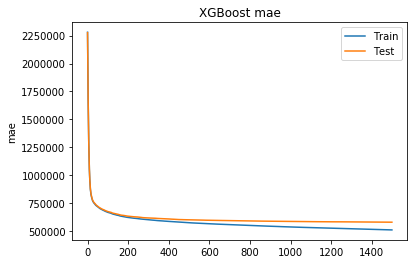

In [93]:
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y,train_size=0.8, random_state = 0)
x_train_procesado = preprocessor.fit_transform(x_train)
x_val_procesado = preprocessor.fit_transform(x_val)
my_pipeline.fit(x_train,y_train, model__eval_set=[(x_train_procesado, y_train.to_numpy()), (x_val_procesado, y_val.to_numpy())])
preds = my_pipeline.predict(x_val)
predictions = [round(value) for value in preds]



'Maxima diferencia al final: 69159.4375'

Text(0.5, 1.0, 'XGBoost mae')

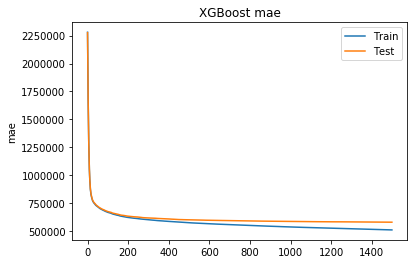

In [104]:
results = model.evals_result()
display("Maxima diferencia al final: " + str(results['validation_1']['mae'][-1] - results['validation_0']['mae'][-1]))
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('mae')
plt.title('XGBoost mae')

In [100]:
results['validation_0']['mae'][-1]

508854.5